Calls served:       2124
Avg wait time:      1.33 min
Total wait time:    2820.73 min


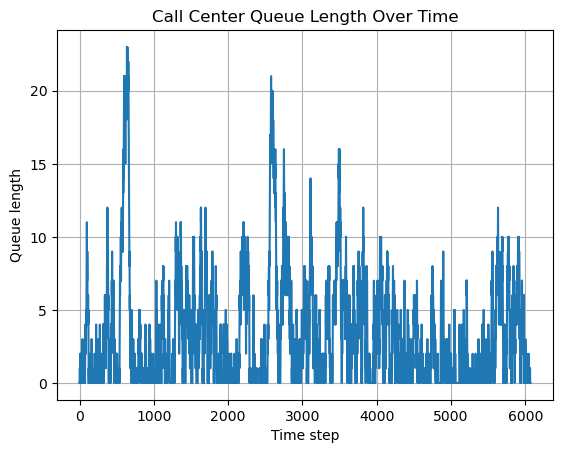

In [2]:
import numpy as np
import queue
import matplotlib.pyplot as plt

# Parameters

np.random.seed(42)
arrival_rate = 3      
service_rate = 1.2     
num_agents = 3
simulation_time = 1000  # minutes
max_queue = 100         # max queue length

# Initialize

current_time = 0
agents = [True] * num_agents
event_list = []  
waiting_queue = queue.Queue(maxsize=max_queue)
wait_times = []
queue_record = []


# Helper functions

def interarrival(): return np.random.exponential(1 / arrival_rate)
def servicetime(): return np.random.exponential(1 / service_rate)

next_arrival = interarrival()

# Simulation Loop
while current_time < simulation_time:
    queue_record.append(waiting_queue.qsize())

    next_departure = min(event_list, key=lambda x: x[0])[0] if event_list else float('inf')

    if next_arrival <= next_departure:
        current_time = next_arrival
        if any(agents):
            aid = agents.index(True)
            agents[aid] = False
            end = current_time + servicetime()
            event_list.append((end, aid, current_time))
        else:
            if not waiting_queue.full():
                waiting_queue.put(current_time)
        next_arrival = current_time + interarrival()
    else:
        current_time, aid, atime = min(event_list, key=lambda x: x[0])
        event_list = [e for e in event_list if e != (current_time, aid, atime)]
        agents[aid] = True
        if not waiting_queue.empty():
            arr_time = waiting_queue.get()
            wait_times.append(current_time - arr_time)
            agents[aid] = False
            end = current_time + servicetime()
            event_list.append((end, aid, arr_time))
# Results

print(f"Calls served:       {len(wait_times)}")
print(f"Avg wait time:      {np.mean(wait_times):.2f} min")
print(f"Total wait time:    {np.sum(wait_times):.2f} min")

plt.plot(queue_record)
plt.xlabel("Time step")
plt.ylabel("Queue length")
plt.title("Call Center Queue Length Over Time")
plt.grid(True)
plt.show()


Value Iteration Policy Results
Calls served:       1880
Avg wait time:      1.53 min
Total wait time:    2869.64 min


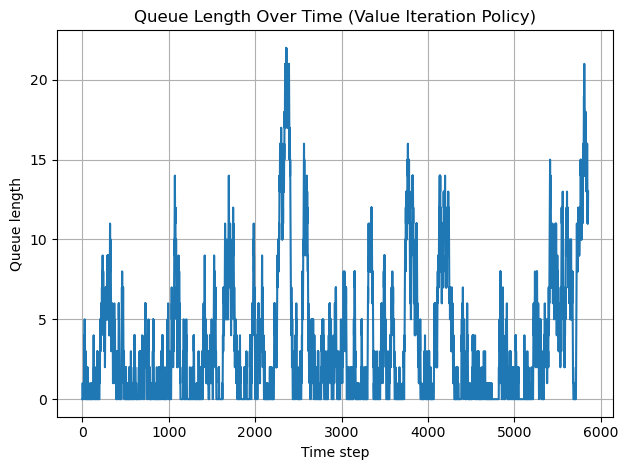

In [26]:
# Parameters 
np.random.seed(42)
arrival_rate = 3.0        
service_rate = 1.2
num_agents = 3
simulation_time = 1000
max_queue_vi = 10         # truncate state space for Value Iteration
dt = 1.0                  # 1 minute time step
gamma = 0.9

# Value Iteration for Call Center MDP
class CallCenterVI:
    def __init__(self, max_q, num_agents, arrival_rate, service_rate, gamma):
        self.max_q = max_q
        self.num_agents = num_agents
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.gamma = gamma
        self.states = [(q, a) for q in range(max_q+1) for a in range(num_agents+1)]
        self.actions = list(range(num_agents+1))
        self.V = {s: 0.0 for s in self.states}
        self.policy = {s: 0 for s in self.states}

    def reward(self, state, action):
        q, _ = state
        return -q  # penalize queue length

    def transition(self, state, action):
        q, idle = state
        busy = self.num_agents - idle
        served = min(q, action)
        busy += served
        expected_depart = self.service_rate * busy * dt
        expected_arrival = self.arrival_rate * dt
        next_q = int(round(min(self.max_q, max(0, q - served - expected_depart + expected_arrival))))
        next_busy = int(round(max(0, min(self.num_agents, busy - expected_depart))))
        next_idle = self.num_agents - next_busy
        return (next_q, next_idle)

    def run_value_iteration(self, theta=1e-3):
        while True:
            delta = 0
            for s in self.states:
                v_old = self.V[s]
                q_vals = []
                for a in self.actions:
                    if a <= s[1]: 
                        ns = self.transition(s, a)
                        r = self.reward(s, a)
                        q_vals.append(r + self.gamma * self.V[ns])
                self.V[s] = max(q_vals) if q_vals else 0
                delta = max(delta, abs(v_old - self.V[s]))
            if delta < theta:
                break
        for s in self.states:
            best_a, best_val = 0, float('-inf')
            for a in self.actions:
                if a <= s[1]:
                    ns = self.transition(s, a)
                    val = self.reward(s, a) + self.gamma * self.V[ns]
                    if val > best_val:
                        best_val = val
                        best_a = a
            self.policy[s] = best_a

# Instantiate and solve
vi = CallCenterVI(max_queue_vi, num_agents, arrival_rate, service_rate, gamma)
vi.run_value_iteration()
policy = vi.policy


# Simulation 
def interarrival(): return np.random.exponential(1 / arrival_rate)
def servicetime(): return np.random.exponential(1 / service_rate)

current_time = 0
agents = [True] * num_agents
event_list = []
waiting_queue = queue.Queue(maxsize=100)
wait_times = []
queue_record = []
next_arrival = interarrival()

while current_time < simulation_time:
    queue_record.append(waiting_queue.qsize())
    next_departure = min(event_list, key=lambda x: x[0])[0] if event_list else float('inf')

    if next_arrival <= next_departure:
        current_time = next_arrival
        if any(agents):
            aid = agents.index(True)
            agents[aid] = False
            end = current_time + servicetime()
            event_list.append((end, aid, current_time))
        else:
            if not waiting_queue.full():
                waiting_queue.put(current_time)
        next_arrival = current_time + interarrival()
    else:
        current_time, aid, arr_time = min(event_list, key=lambda x: x[0])
        event_list = [e for e in event_list if e != (current_time, aid, arr_time)]
        agents[aid] = True
        if not waiting_queue.empty():
            arr_t = waiting_queue.get()
            wait_times.append(current_time - arr_t)
            state = (min(waiting_queue.qsize(), max_queue_vi), agents.count(True))
            to_assign = min(policy[state], agents.count(True), waiting_queue.qsize() + 1)
            if to_assign > 0:
                agents[aid] = False
                end = current_time + servicetime()
                event_list.append((end, aid, arr_t))

# Results
print("Value Iteration Policy Results")
print(f"Calls served:       {len(wait_times)}")
print(f"Avg wait time:      {np.mean(wait_times):.2f} min")
print(f"Total wait time:    {np.sum(wait_times):.2f} min")

plt.plot(queue_record)
plt.xlabel("Time step")
plt.ylabel("Queue length")
plt.title("Queue Length Over Time (Value Iteration Policy)")
plt.grid(True)
plt.tight_layout()
plt.show()


Policy Iteration Policy Results
Calls served:       1675
Avg wait time:      1.31 min
Total wait time:    2195.67 min


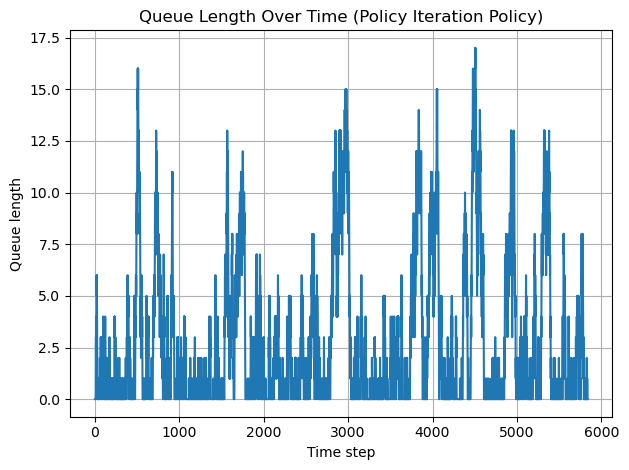

In [28]:

# Policy Iteration for Call Center MDP
class CallCenterPI:
    def __init__(self, max_q, num_agents, arrival_rate, service_rate, gamma):
        self.max_q = max_q
        self.num_agents = num_agents
        self.arrival_rate = arrival_rate
        self.service_rate = service_rate
        self.gamma = gamma
        self.states = [(q, a) for q in range(max_q+1) for a in range(num_agents+1)]
        self.actions = list(range(num_agents+1))
        self.V = {s: 0.0 for s in self.states}
        self.policy = {s: 0 for s in self.states}

    def reward(self, state, action):
        q, _ = state
        return -q

    def transition(self, state, action):
        q, idle = state
        busy = self.num_agents - idle
        served = min(q, action)
        busy += served
        expected_depart = self.service_rate * busy * dt
        expected_arrival = self.arrival_rate * dt
        next_q = int(round(min(self.max_q, max(0, q - served - expected_depart + expected_arrival))))
        next_busy = int(round(max(0, min(self.num_agents, busy - expected_depart))))
        next_idle = self.num_agents - next_busy
        return (next_q, next_idle)

    def policy_evaluation(self, theta=1e-3):
        while True:
            delta = 0
            for s in self.states:
                a = self.policy[s]
                ns = self.transition(s, a)
                r = self.reward(s, a)
                v_new = r + self.gamma * self.V[ns]
                delta = max(delta, abs(self.V[s] - v_new))
                self.V[s] = v_new
            if delta < theta:
                break

    def policy_improvement(self):
        policy_stable = True
        for s in self.states:
            old_a = self.policy[s]
            best_a = old_a
            best_val = float('-inf')
            for a in self.actions:
                if a <= s[1]:
                    ns = self.transition(s, a)
                    val = self.reward(s, a) + self.gamma * self.V[ns]
                    if val > best_val:
                        best_val = val
                        best_a = a
            self.policy[s] = best_a
            if best_a != old_a:
                policy_stable = False
        return policy_stable

    def run_policy_iteration(self):
        while True:
            self.policy_evaluation()
            if self.policy_improvement():
                break

pi = CallCenterPI(max_queue_vi, num_agents, arrival_rate, service_rate, gamma)
pi.run_policy_iteration()
pi_policy = pi.policy


# Simulation 
current_time = 0
agents = [True] * num_agents
event_list = []
waiting_queue = queue.Queue(maxsize=100)
wait_times = []
queue_record = []
next_arrival = interarrival()

while current_time < simulation_time:
    queue_record.append(waiting_queue.qsize())
    next_departure = min(event_list, key=lambda x: x[0])[0] if event_list else float('inf')

    if next_arrival <= next_departure:
        current_time = next_arrival
        if any(agents):
            aid = agents.index(True)
            agents[aid] = False
            end = current_time + servicetime()
            event_list.append((end, aid, current_time))
        else:
            if not waiting_queue.full():
                waiting_queue.put(current_time)
        next_arrival = current_time + interarrival()
    else:
        current_time, aid, arr_time = min(event_list, key=lambda x: x[0])
        event_list = [e for e in event_list if e != (current_time, aid, arr_time)]
        agents[aid] = True
        if not waiting_queue.empty():
            arr_t = waiting_queue.get()
            wait_times.append(current_time - arr_t)
            state = (min(waiting_queue.qsize(), max_queue_vi), agents.count(True))
            to_assign = min(pi_policy[state], agents.count(True), waiting_queue.qsize() + 1)
            if to_assign > 0:
                agents[aid] = False
                end = current_time + servicetime()
                event_list.append((end, aid, arr_t))


# Results

print("Policy Iteration Policy Results")
print(f"Calls served:       {len(wait_times)}")
print(f"Avg wait time:      {np.mean(wait_times):.2f} min")
print(f"Total wait time:    {np.sum(wait_times):.2f} min")

plt.plot(queue_record)
plt.xlabel("Time step")
plt.ylabel("Queue length")
plt.title("Queue Length Over Time (Policy Iteration Policy)")
plt.grid(True)
plt.tight_layout()
plt.show()
